In [1]:
# Automated trading script for OANDA - SMA crossover

import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.trades as trades
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
#initiating API connection and defining trade parameters
token_path = "/Users/oozdal/keys/oanda.txt"
TOKEN = open(token_path,'r').read()
TOKEN = TOKEN[0:65]
client = oandapyV20.API(access_token=TOKEN, environment="practice")  # open(token_path,'r').read()

In [3]:
account_id = "101-002-19239803-001"

In [4]:
#defining strategy parameters
pairs = ['EUR_USD','GBP_USD','USD_CHF','AUD_USD','USD_CAD'] #currency pairs to be included in the strategy
#pairs = ['EUR_JPY','USD_JPY','AUD_JPY','AUD_USD','AUD_NZD','NZD_USD']
pos_size = 2000 #max capital allocated/position size for any currency pair
upward_sma_dir = {}
dnward_sma_dir = {}
for i in pairs:
    upward_sma_dir[i] = False
    dnward_sma_dir[i] = False

In [5]:
def stochastic(df,a,b,c):
    "function to calculate stochastic"
    df['k']=((df['c'] - df['l'].rolling(a).min())/(df['h'].rolling(a).max()-df['l'].rolling(a).min()))*100
    df['K']=df['k'].rolling(b).mean() 
    df['D']=df['K'].rolling(c).mean()
    return df

In [6]:
def SMA(df,a,b):
    "function to calculate stochastic"
    df['sma_fast']=df['c'].rolling(a).mean() 
    df['sma_slow']=df['c'].rolling(b).mean() 
    return df

In [7]:
def candles(instrument):
    params = {"count": 800,"granularity": "M5"} #granularity can be in seconds S5 - S30, minutes M1 - M30, hours H1 - H12, days D, weeks W or months M
    candles = instruments.InstrumentsCandles(instrument=instrument,params=params)
    client.request(candles)
    ohlc_dict = candles.response["candles"]
    ohlc = pd.DataFrame(ohlc_dict)
    ohlc_df = ohlc.mid.dropna().apply(pd.Series)
    ohlc_df["volume"] = ohlc["volume"]
    ohlc_df.index = ohlc["time"]
    ohlc_df = ohlc_df.apply(pd.to_numeric)
    return ohlc_df

In [8]:
def market_order(instrument,units,sl):
    """units can be positive or negative, stop loss (in pips) added/subtracted to price """  
    account_id = "101-002-19239803-001"
    data = {
            "order": {
            "price": "",
            "stopLossOnFill": {
            "trailingStopLossOnFill": "GTC",
            "distance": str(sl)
                              },
            "timeInForce": "FOK",
            "instrument": str(instrument),
            "units": str(units),
            "type": "MARKET",
            "positionFill": "DEFAULT"
                    }
            }
    r = orders.OrderCreate(accountID=account_id, data=data)
    client.request(r)

In [9]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['h']-df['l'])
    df['H-PC']=abs(df['h']-df['c'].shift(1))
    df['L-PC']=abs(df['l']-df['c'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return round(df2["ATR"][-1],2)

In [10]:
def trade_signal(df,curr):
    "function to generate signal"
    global upward_sma_dir, dnward_sma_dir
    signal = ""
    if df['sma_fast'][-1] > df['sma_slow'][-1] and df['sma_fast'][-2] < df['sma_slow'][-2]:
        upward_sma_dir[curr] = True
        dnward_sma_dir[curr] = False
    if df['sma_fast'][-1] < df['sma_slow'][-1] and df['sma_fast'][-2] > df['sma_slow'][-2]:
        upward_sma_dir[curr] = False
        dnward_sma_dir[curr] = True  
    if upward_sma_dir[curr] == True and min(df['K'][-1],df['D'][-1]) > 25 and max(df['K'][-2],df['D'][-2]) < 25:
        signal = "Buy"
    if dnward_sma_dir[curr] == True and min(df['K'][-1],df['D'][-1]) > 75 and max(df['K'][-2],df['D'][-2]) < 75:
        signal = "Sell"

    plt.subplot(211)
    plt.plot(df.iloc[-50:,[3,-2,-1]])
    plt.title('SMA Crossover & Stochastic')
    plt.legend(('close','sma_fast','sma_slow'),loc='upper left')
    
    plt.subplot(212)
    plt.plot(df.iloc[-50:,[-4,-3]])
    plt.hlines(y=25,xmin=0,xmax=50,linestyles='dashed')
    plt.hlines(y=75,xmin=0,xmax=50,linestyles='dashed')
    plt.show()
    
    return signal

In [11]:
def main():
    global pairs
    try:
        r = trades.OpenTrades(accountID=account_id)
        open_trades = client.request(r)['trades']
        curr_ls = []
        for i in range(len(open_trades)):
            curr_ls.append(open_trades[i]['instrument'])
        pairs = [i for i in pairs if i not in curr_ls]
        for currency in pairs:
            print("analyzing ",currency)
            data = candles(currency)
            ohlc_df = stochastic(data,14,3,3)
            ohlc_df = SMA(ohlc_df,100,200)
            signal = trade_signal(ohlc_df,currency)
            if signal == "Buy":
                market_order(currency,pos_size,3*ATR(data,120))
                print("New long position initiated for ", currency)
            elif signal == "Sell":
                market_order(currency,-1*pos_size,3*ATR(data,120))
                print("New short position initiated for ", currency)
    except:
        print("error encountered....skipping this iteration")

passthrough at  2021-05-14 21:52:51
analyzing  EUR_USD


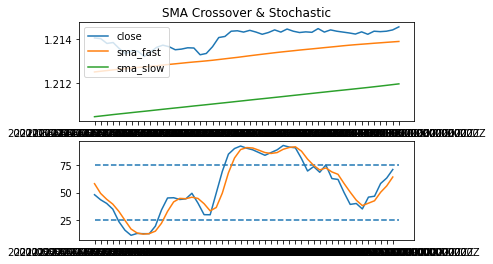

analyzing  GBP_USD


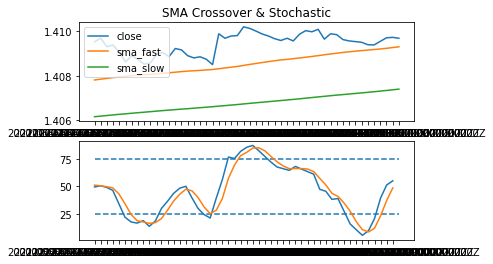

analyzing  USD_CHF


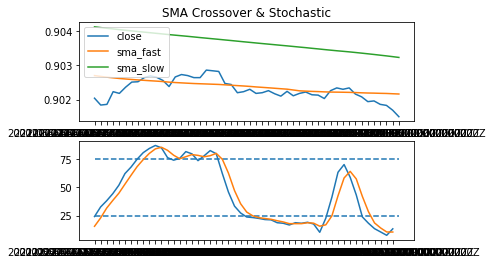

analyzing  AUD_USD


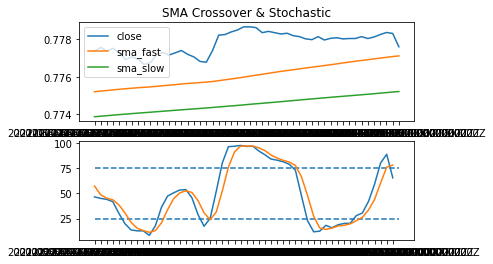

analyzing  USD_CAD


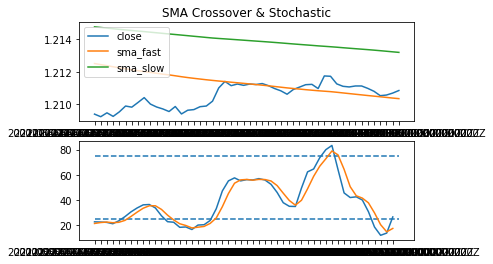

passthrough at  2021-05-14 21:57:51
analyzing  EUR_USD


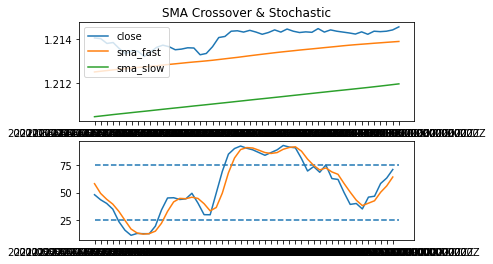

analyzing  GBP_USD


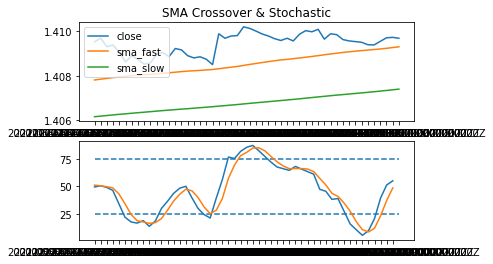

analyzing  USD_CHF


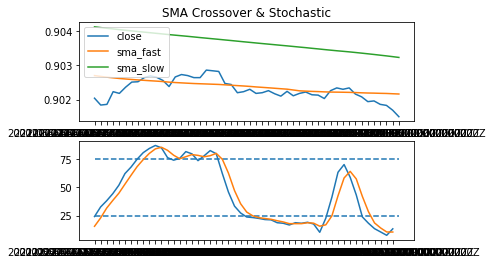

analyzing  AUD_USD


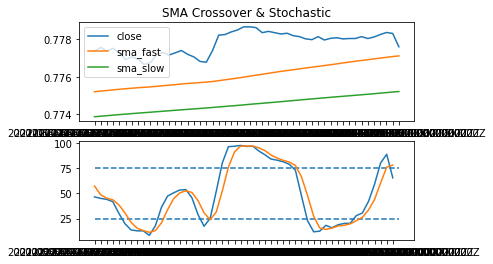

analyzing  USD_CAD


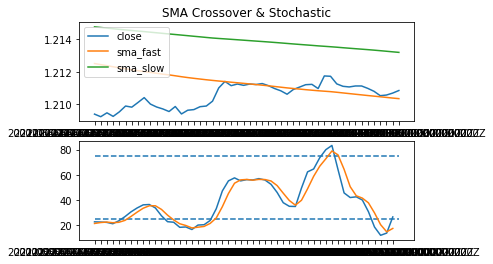

passthrough at  2021-05-14 22:02:51
analyzing  EUR_USD


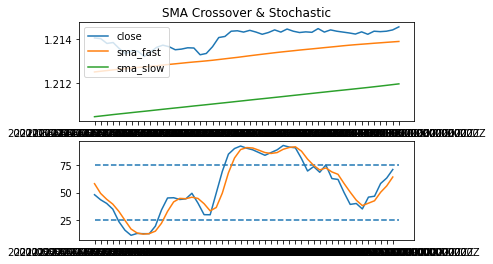

analyzing  GBP_USD


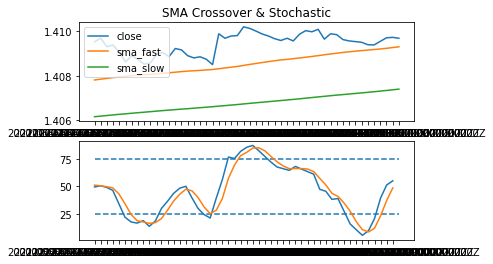

analyzing  USD_CHF


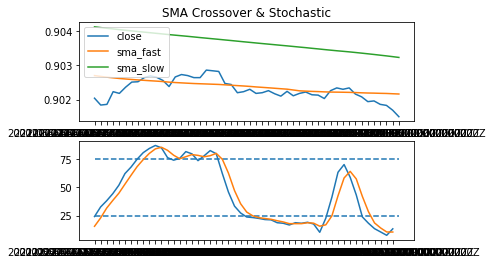

analyzing  AUD_USD


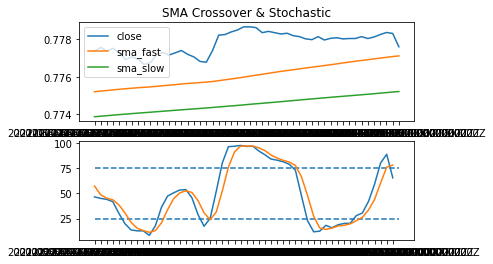

analyzing  USD_CAD


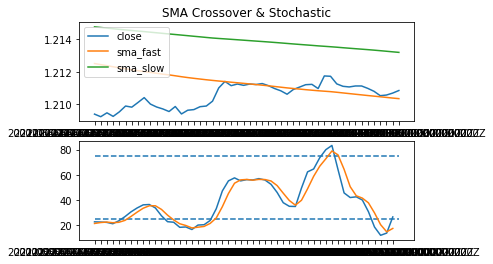

passthrough at  2021-05-14 22:07:51
analyzing  EUR_USD


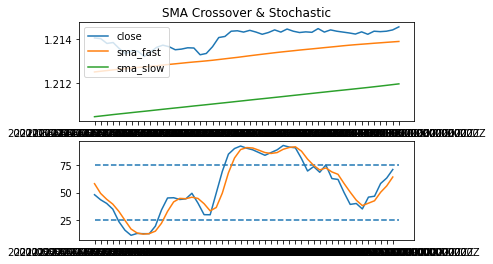

analyzing  GBP_USD


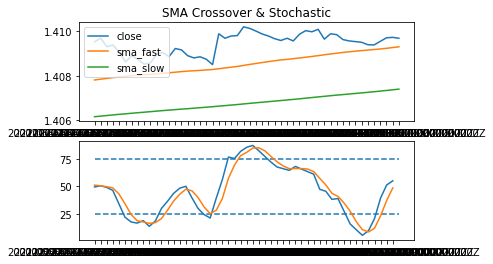

analyzing  USD_CHF


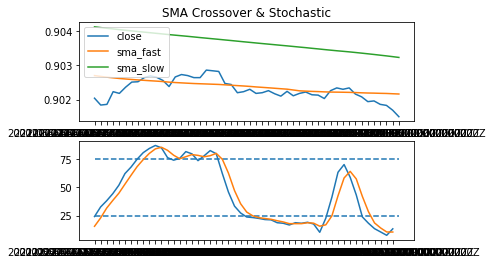

analyzing  AUD_USD


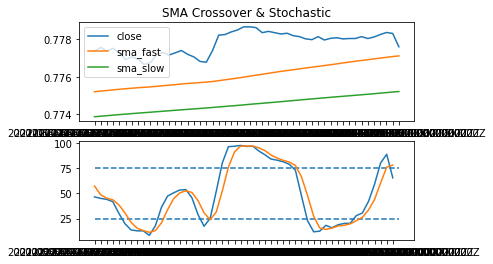

analyzing  USD_CAD


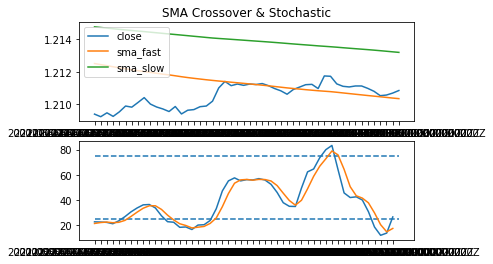

passthrough at  2021-05-14 22:12:51
analyzing  EUR_USD


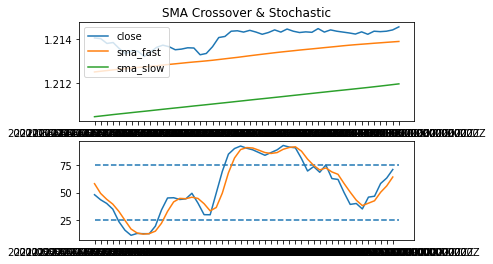

analyzing  GBP_USD


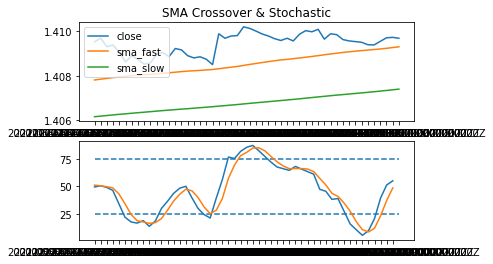

analyzing  USD_CHF


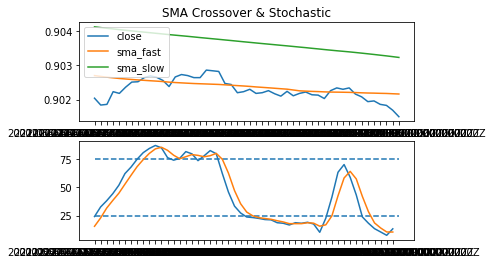

analyzing  AUD_USD


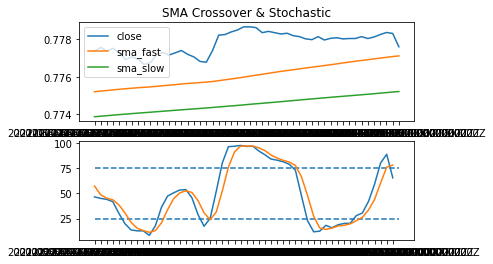

analyzing  USD_CAD


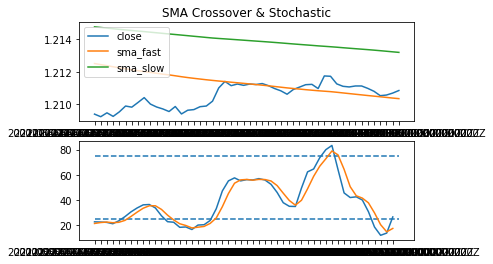

passthrough at  2021-05-14 22:17:51
analyzing  EUR_USD


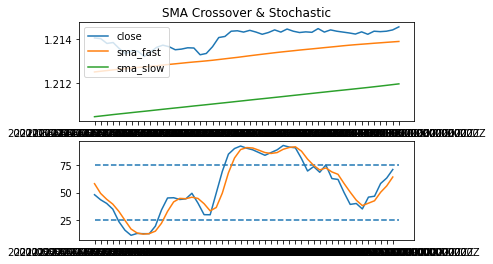

analyzing  GBP_USD


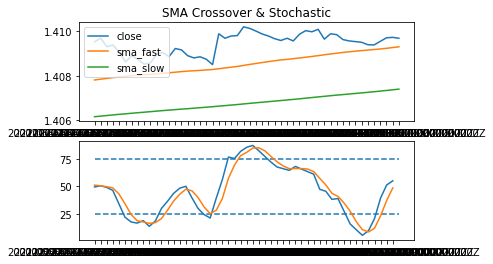

analyzing  USD_CHF


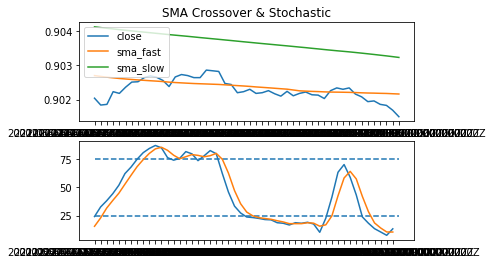

analyzing  AUD_USD


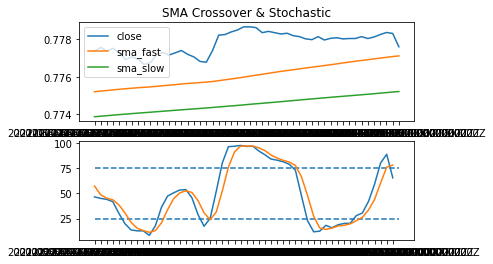

analyzing  USD_CAD


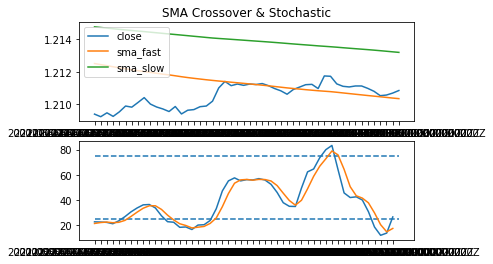

passthrough at  2021-05-14 22:22:51
analyzing  EUR_USD


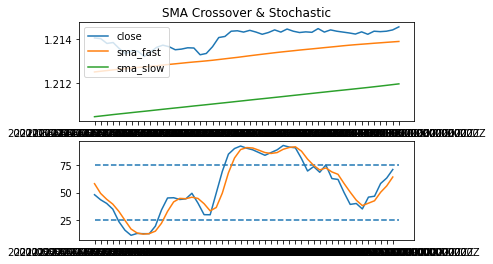

analyzing  GBP_USD


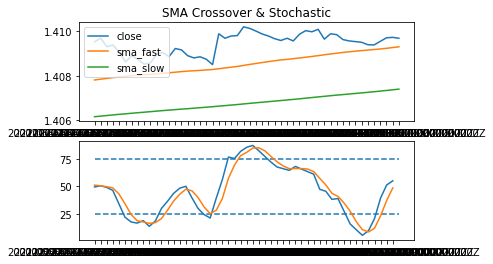

analyzing  USD_CHF


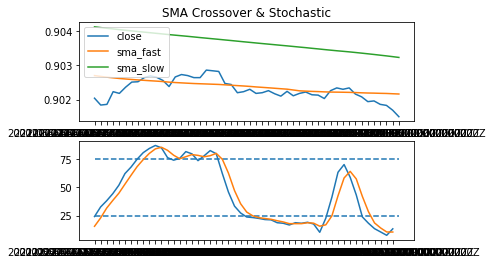

analyzing  AUD_USD


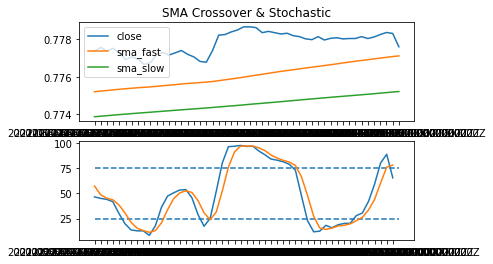

analyzing  USD_CAD


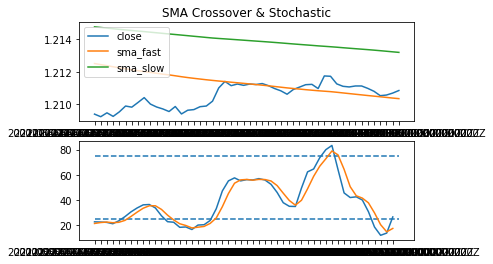

passthrough at  2021-05-14 22:27:51
analyzing  EUR_USD


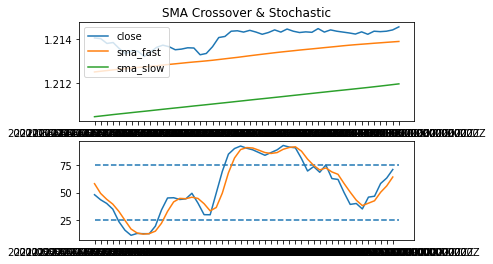

analyzing  GBP_USD


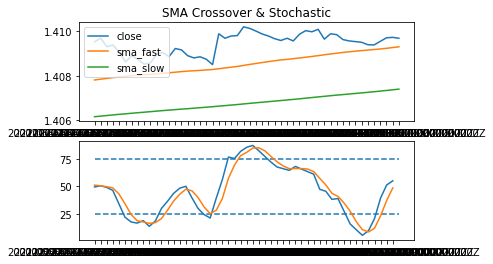

analyzing  USD_CHF


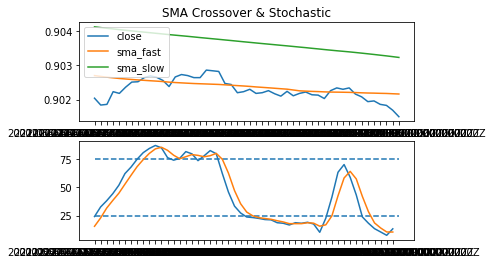

analyzing  AUD_USD


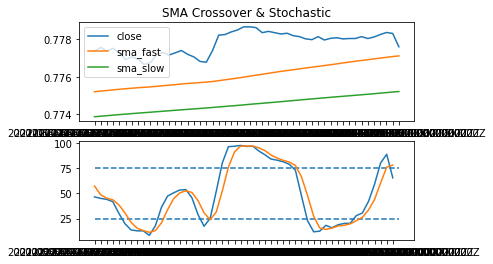

analyzing  USD_CAD


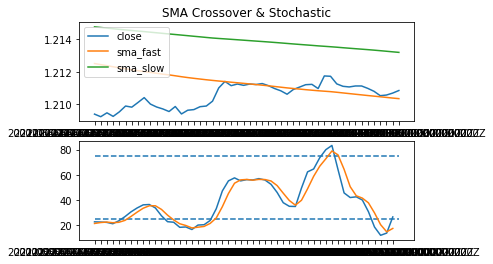

passthrough at  2021-05-14 22:32:51
analyzing  EUR_USD


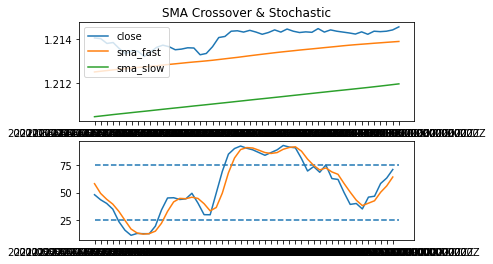

analyzing  GBP_USD


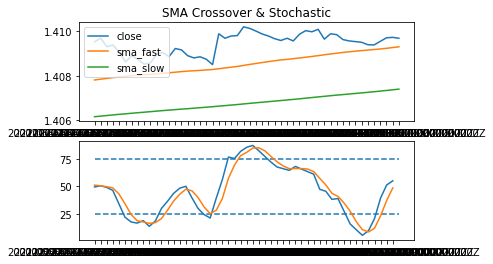

analyzing  USD_CHF


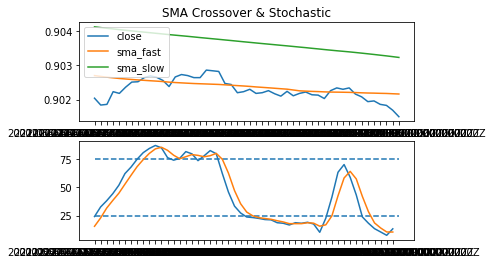

analyzing  AUD_USD


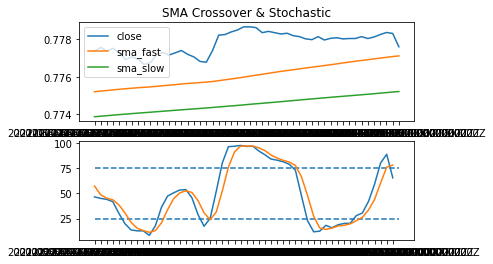

analyzing  USD_CAD


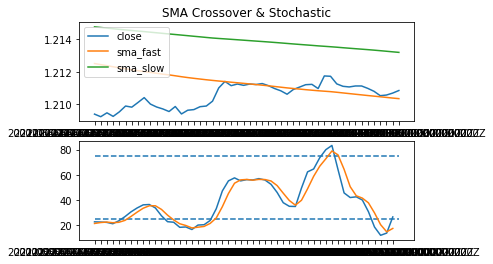

passthrough at  2021-05-14 22:37:51
analyzing  EUR_USD


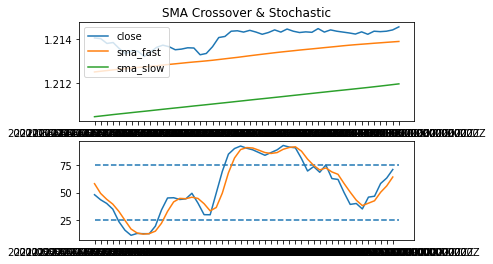

analyzing  GBP_USD


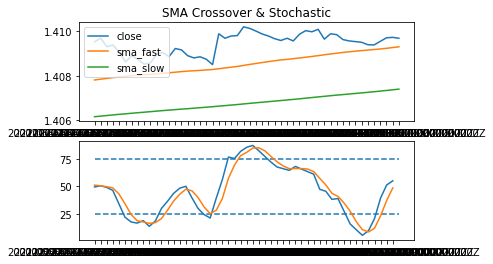

analyzing  USD_CHF


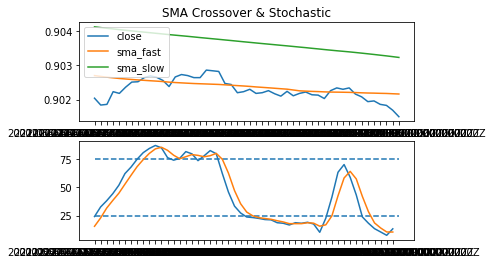

analyzing  AUD_USD


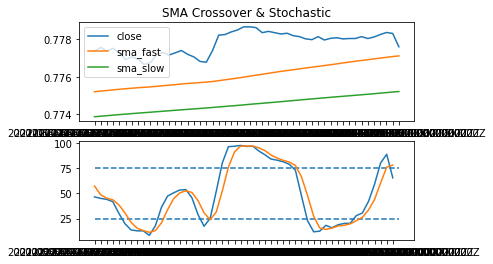

analyzing  USD_CAD


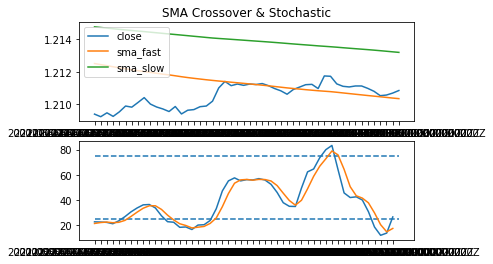

passthrough at  2021-05-14 22:42:51
analyzing  EUR_USD


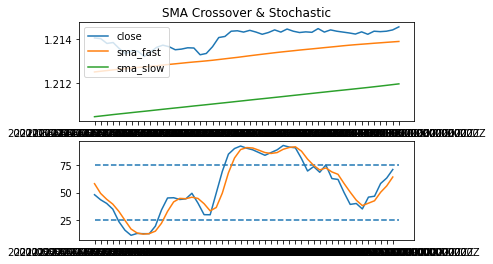

analyzing  GBP_USD


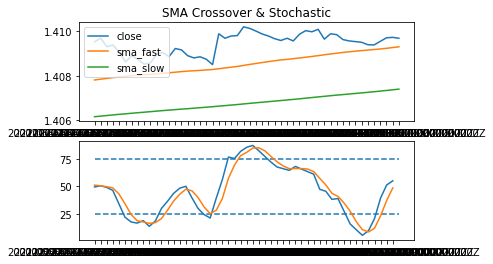

analyzing  USD_CHF


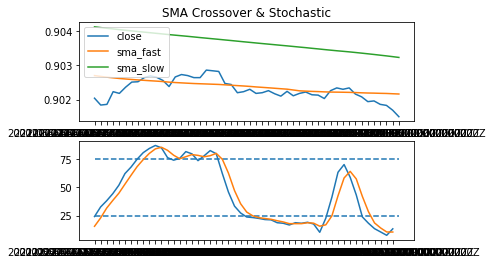

analyzing  AUD_USD


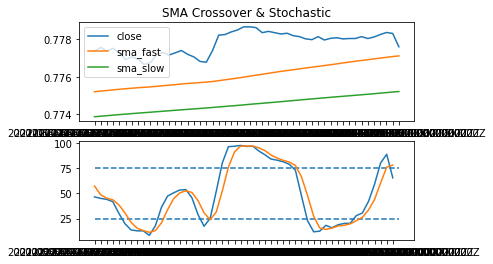

analyzing  USD_CAD


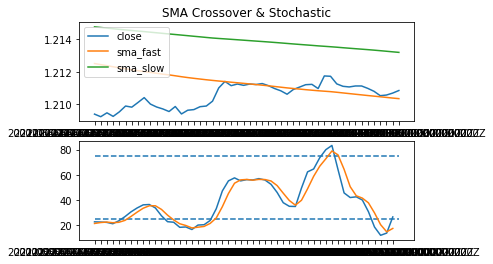

passthrough at  2021-05-14 22:47:51
analyzing  EUR_USD


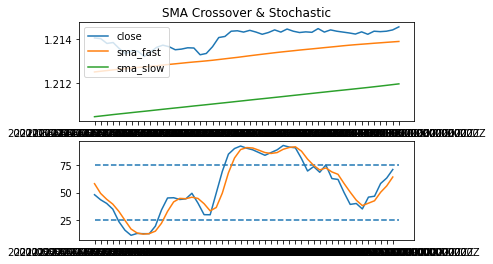

analyzing  GBP_USD


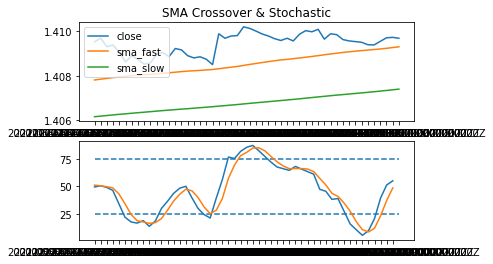

analyzing  USD_CHF


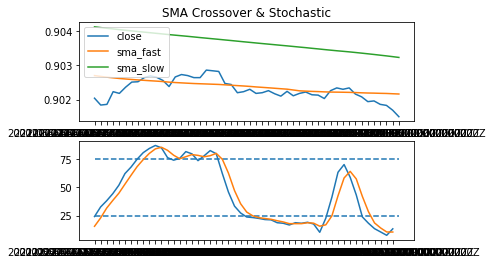

analyzing  AUD_USD


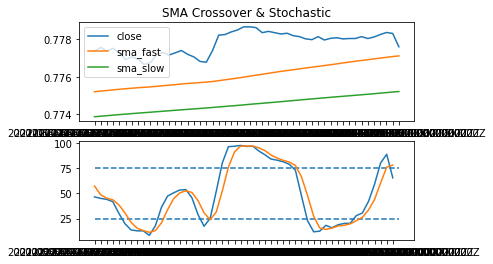

analyzing  USD_CAD


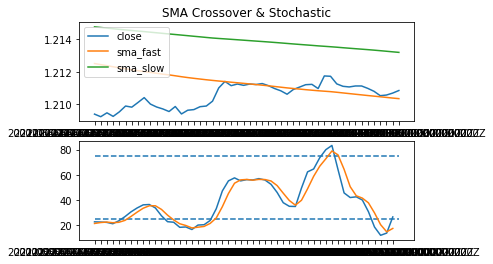

In [12]:
# Continuous execution        
starttime=time.time()
timeout = time.time() + 60*60*1  # 60 seconds times 60 meaning the script will run for 1 hr
while time.time() <= timeout:
    try:
        print("passthrough at ",time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        main()
        time.sleep(300 - ((time.time() - starttime) % 300.0)) # 5 minute interval between each new execution
    except KeyboardInterrupt:
        print('\n\nKeyboard exception received. Exiting.')
        exit()